In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from scipy.optimize import minimize

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [33]:
box_length=20E-6
inserted_res_length = 80

xeval = np.linspace(-4.0, box_length*1E6, 1001)
yeval = anneal.construct_symmetric_y(-4.0, 201)

dx = np.diff(xeval)[0]*1E-6
dy = np.diff(yeval)[0]*1E-6

master_path = r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2"
#r"/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/M018V4"

x_eval, y_eval, output = anneal.load_data(master_path, xeval=xeval, yeval=yeval, mirror_y=True,
                                          extend_resonator=False, insert_resonator=True, do_plot=False,
                                          inserted_res_length=inserted_res_length, smoothen_xy=(0.25E-6, dy))

Resonator data was inserted from x = 9.39 um to x = 89.38 um


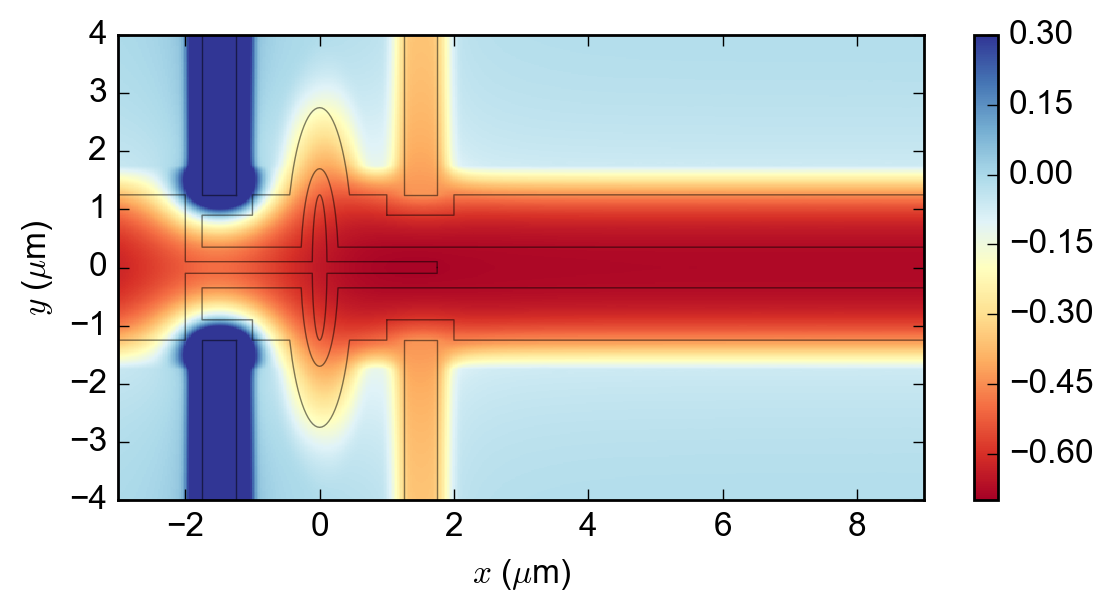

In [34]:
coefficients = [1.00, 0.98, 0.40, -1.50]

for i, c in enumerate(coefficients):
    if i == 0:
        potential_data = output[i]['V'] * c
    else: 
        potential_data += output[i]['V'] * c 

PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=+0.30, vmin=-0.70)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-3,9)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")

In [35]:
CMS = anneal.TrapAreaSolver(x_eval[0,:], y_eval[:,0], -potential_data,
                            spline_order_x=3, spline_order_y=3, smoothing=0.01,
                            include_screening=True, screening_length=2*0.75E-6)

In [ ]:
X_eval, Y_eval = np.meshgrid(x_eval[0,:], y_eval[:,0])

In [37]:
# Solve for the electron positions in the trap area!
ConvMon = anneal.ConvergenceMonitor(Uopt=CMS.Vtotal, grad_Uopt=CMS.grad_total, N=1,
                                    Uext=CMS.V, xext=np.arange(-2E-6, 6E-6, dx), yext=y_eval[:,0], verbose=True, eps=1E-10,
                                    figsize=(6.5, 3.0), clim=(-0.75, 0.30),
                                    save_path=r"/Users/gkoolstra/Desktop/Single electron loading/Anneal example")

ConvMon.figsize = (6.5, 3.0)
ConvMon.electrode_outline_filename = r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf"

N_electrons = 160
N_rows = N_electrons
row_spacing = 0.10E-6
N_cols = 1
col_spacing = 0.10E-6

electron_initial_positions = anneal.get_rectangular_initial_condition(N_electrons, N_rows=N_rows, N_cols=N_cols,
                                                                      x0=(inserted_res_length*1E-6 + box_length)/2., 
                                                                      y0=0.0E-6, dx=0.20E-6)

trap_minimizer_options = {'jac': CMS.grad_total,
                          'options': {'disp': False, 'gtol': 1E2, 'eps': 1E-10},
                          'callback': ConvMon.monitor_convergence}

res = minimize(CMS.Vtotal, electron_initial_positions, method='L-BFGS-B', **trap_minimizer_options)

print(res['message'])

0	Uopt: -106.81212871 eV	Norm of gradient: 8.46e+03 eV/m
1	Uopt: -106.83427937 eV	Norm of gradient: 7.22e+03 eV/m
2	Uopt: -106.86321630 eV	Norm of gradient: 6.62e+03 eV/m
3	Uopt: -106.92920027 eV	Norm of gradient: 6.15e+03 eV/m
4	Uopt: -106.96051291 eV	Norm of gradient: 1.64e+04 eV/m
5	Uopt: -107.01639498 eV	Norm of gradient: 1.09e+05 eV/m
6	Uopt: -107.05358885 eV	Norm of gradient: 1.38e+05 eV/m
7	Uopt: -107.13058163 eV	Norm of gradient: 1.09e+05 eV/m
8	Uopt: -107.16335400 eV	Norm of gradient: 1.89e+05 eV/m
9	Uopt: -107.16876135 eV	Norm of gradient: 1.93e+05 eV/m
10	Uopt: -107.18005659 eV	Norm of gradient: 1.90e+05 eV/m
11	Uopt: -107.20998682 eV	Norm of gradient: 6.42e+04 eV/m
12	Uopt: -107.24312693 eV	Norm of gradient: 3.07e+04 eV/m
13	Uopt: -107.24844789 eV	Norm of gradient: 2.93e+04 eV/m
14	Uopt: -107.29567525 eV	Norm of gradient: 3.97e+04 eV/m
15	Uopt: -107.31133498 eV	Norm of gradient: 8.73e+04 eV/m
16	Uopt: -107.32095120 eV	Norm of gradient: 6.69e+04 eV/m
17	Uopt: -107.34407510 e

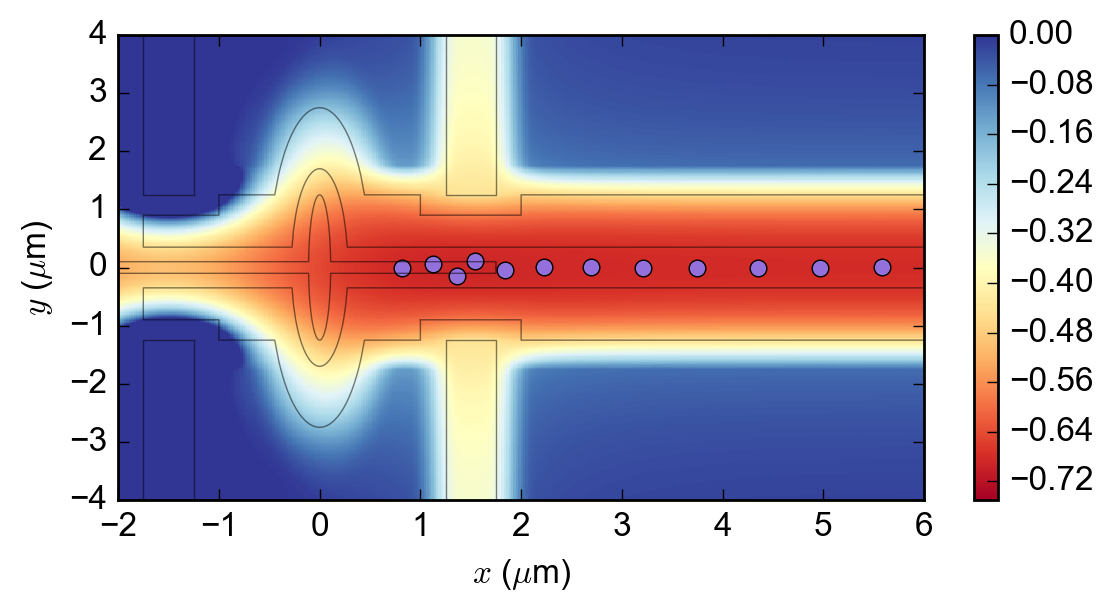

In [38]:
PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))
common.configure_axes(12)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=0.0, vmin=-0.75)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.plot(res['x'][::2] * 1E6, res['x'][1::2] * 1E6 , 'o', color="mediumpurple")
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-2,6)
plt.ylim(-4,4)

plt.colorbar()
plt.show()

#common.save_figure(fig2, save_path=r"/Users/gkoolstra/Google Drive/grad school/schuster lab/Presentations/March Meeting 2017")

In [20]:
ConvMon.curr_xk

array([[  4.14361654e-05,  -1.47902465e-07,   4.14361654e-05, ...,
         -1.47902465e-07,   5.85638346e-05,   1.47902465e-07],
       [  4.14361654e-05,  -1.47902465e-07,   4.14361654e-05, ...,
         -1.47902465e-07,   5.85638346e-05,   1.47902465e-07],
       [  3.97530043e-05,  -2.78438662e-07,   3.97530043e-05, ...,
         -2.78438662e-07,   6.02469957e-05,   2.78438662e-07],
       ..., 
       [  1.15730365e-06,   9.22472412e-09,   8.40845340e-07, ...,
         -4.09838664e-08,   9.35598593e-05,   1.78964070e-09],
       [  1.15984112e-06,   8.59492846e-09,   8.39377465e-07, ...,
         -4.08209098e-08,   9.35616210e-05,   1.70432742e-09],
       [  1.15821973e-06,   8.54271129e-09,   8.40467606e-07, ...,
         -4.08582886e-08,   9.35611551e-05,   2.31999075e-09]])

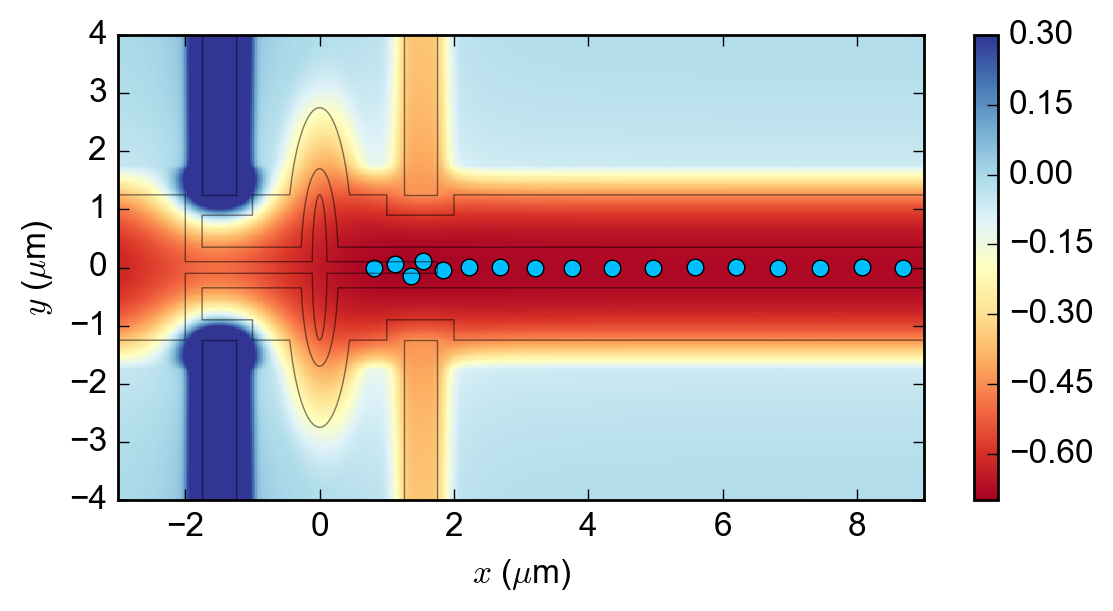

In [39]:
PP = anneal.PostProcess(save_path=None)

# Plot the resonator and trap electron configuration
fig2 = plt.figure(figsize=(6.5, 3))

ax = fig2.add_subplot(111)
plt.pcolormesh(x_eval[0,:] * 1E6, y_eval[:,0] * 1E6, -potential_data.T, cmap=plt.cm.RdYlBu, vmax=+0.30, vmin=-0.70)
line1, = plt.plot(ConvMon.curr_xk[0,::2] * 1E6, ConvMon.curr_xk[0,1::2] * 1E6, 'o', color='deepskyblue')

common.configure_axes(12)

plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.plot(ConvMon.curr_xk[0,::2] * 1E6, ConvMon.curr_xk[0,1::2] * 1E6 , 'o', color='deepskyblue')
#plt.xlim(np.min(x_eval)*1E6, 10)
#plt.ylim(np.min(y_eval)*1E6, np.max(y_eval)*1E6)
PP.draw_from_dxf(r"/Users/gkoolstra/Desktop/Single electron loading/Potentials/M018V6/V6.2/all_electrodes.dxf", 
                 color='black', alpha=0.5, lw=0.5)

plt.xlim(-3,9)
plt.ylim(-4,4)

plt.colorbar()

for el in range(np.shape(ConvMon.curr_xk[1:,:])[0]):
    line1.set_ydata(ConvMon.curr_xk[el,1::2] * 1E6)
    line1.set_xdata(ConvMon.curr_xk[el,::2] * 1E6)
    fig2.canvas.draw()
    
    common.save_figure(fig2, save_path = r"/Users/gkoolstra/Desktop/Single electron loading/Data/Annealing Examples/M018V6.2 (80 um box and 160 electrons)")
#plt.close(fig2)